In [3]:
import dgl
import torch
from dgl.data.utils import save_graphs
from datetime import date, timedelta

graphs = []

start_date = date(2016, 1, 1)
end_date = date(2016, 12, 31)
delta = timedelta(days=1)
while start_date <= end_date:
    # 根据日期生成文件名
    file_name = "2016/graph" + start_date.strftime("%Y%m%d") + ".dgl"
    (g,), _ = dgl.load_graphs(file_name)
    # 将图添加到列表中
    graphs.append(g)
    start_date += delta

print("Number of graphs:", len(graphs))


Number of graphs: 366


In [4]:
subgraphs = graphs[:20]

# 批处理子图成一个图
g = dgl.batch(subgraphs)

print("Batched graph:", g)


Batched graph: Graph(num_nodes=210136, num_edges=1173138,
      ndata_schemes={'O_WSPD': Scheme(shape=(1,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'O_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'O_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'DISTANCE': Scheme(shape=(1,), dtype=torch.float32), 'O_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'O_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'D_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'feat': Scheme(shape=(15,), dtype=torch.float32), 'D_PRCP': Schem

In [5]:
#划分数据集，这里取的前20个测试
#更大规模的无法直接运行
subgraphs = dgl.unbatch(g)
train_set = subgraphs[:16]
valid_set = subgraphs[16:18]
test_set = subgraphs[18:]

train_g = dgl.batch(train_set)
valid_g = dgl.batch(valid_set)
test_g = dgl.batch(test_set)

print("Train set:", train_g)
print("Valid set:", valid_g)
print("Test set:", test_g)


Train set: Graph(num_nodes=168149, num_edges=937260,
      ndata_schemes={'O_WSPD': Scheme(shape=(1,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'O_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'O_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'DISTANCE': Scheme(shape=(1,), dtype=torch.float32), 'O_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'O_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'D_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'feat': Scheme(shape=(15,), dtype=torch.float32), 'D_PRCP': Scheme(sha

In [6]:
# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('使用设备:', device)

使用设备: cuda


In [7]:
train_g = train_g.to(device)
valid_g = valid_g.to(device)
test_g = test_g.to(device)

In [8]:
train_g

Graph(num_nodes=168149, num_edges=937260,
      ndata_schemes={'O_WSPD': Scheme(shape=(1,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'O_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'O_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'DISTANCE': Scheme(shape=(1,), dtype=torch.float32), 'O_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'O_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'D_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'feat': Scheme(shape=(15,), dtype=torch.float32), 'D_PRCP': Scheme(shape=(1,), dt

In [9]:
train_features = train_g.ndata['feat']
train_labels = train_g.ndata['label']
valid_features = valid_g.ndata['feat']
valid_labels = valid_g.ndata['label']
test_features = test_g.ndata['feat']
test_labels = test_g.ndata['label']


In [10]:
train_features = train_features.to(device)
valid_features = valid_features.to(device)
test_features = test_features.to(device)


In [11]:
import dgl
import torch
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')
    
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h



In [18]:
import time 

loss_list = []
loss_test_list = []

start_time = time.perf_counter() 

# 输入特征维度
n_features = train_features.shape[1]

# 实例化一个SAGE模型
model = SAGE(in_feats=n_features, hid_feats=300, out_feats=1)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01) 


for epoch in range(20000):
    model.train()
    train_pred = model(train_g, train_features)
    train_loss = F.mse_loss(train_pred, train_labels)
    valid_pred = model(valid_g, valid_features)
    valid_loss = F.mse_loss(valid_pred, valid_labels)
    test_pred = model(test_g, test_features)
    test_loss = F.mse_loss(test_pred, test_labels)
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    # 将损失值添加到列表中
    loss_list.append(train_loss.item())
    loss_test_list.append(test_loss.item())

end_time = time.perf_counter() 
elapsed_time = end_time - start_time 
print(f"Training took {elapsed_time} seconds.") 


Training took 439.14114380000683 seconds.


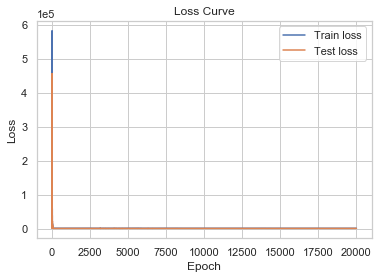

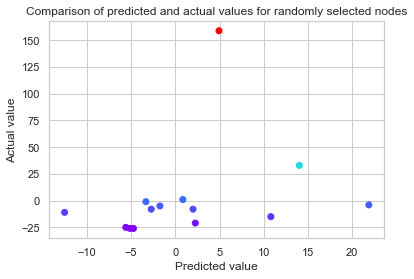

In [19]:
import matplotlib.pyplot as plt
import numpy as np

loss_train = np.array(loss_list)
loss_test = np.array(loss_test_list)
# 绘制训练集和测试集的损失曲线
plt.plot(loss_train, label="Train loss")
plt.plot(loss_test, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.savefig("loss_plot.png", dpi=1000)
plt.show()

# 对测试集中的一些节点进行预测和比较
nodes = [1, 6, 9, 55, 554, 364, 51, 166, 244, 365, 644, 431, 2, 65]
preds = test_pred[nodes].cpu().detach().numpy()
labels = test_labels[nodes].cpu().detach().numpy()
plt.scatter(preds, labels, c=labels, cmap='rainbow')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Comparison of predicted and actual values for randomly selected nodes')
plt.show()


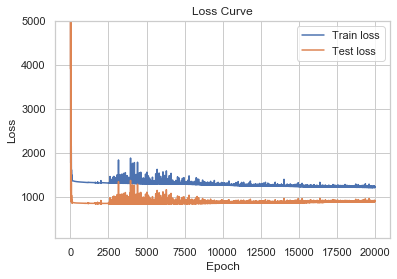

In [20]:
    plt.plot(loss_train, label="Train loss")
    plt.plot(loss_test, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("loss_plot.png", dpi=1000)
    plt.ylim(50, 5000)
    plt.show()

In [21]:
test_labels

tensor([[ -3.],
        [-26.],
        [-26.],
        ...,
        [  0.],
        [  0.],
        [  0.]], device='cuda:0')

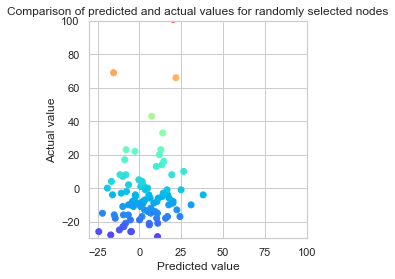

In [25]:
np.random.seed(42)
nodes=np.arange(1,100,1)

#print(pred[nodes])
#print(node_labels[nodes])
# 绘制散点图，横轴为预测值，纵轴为实际值，颜色为节点的类别
preds=test_pred[nodes].cpu().detach().numpy()
labels=test_labels[nodes].cpu().detach().numpy()

plt.scatter(preds, labels, c=labels, cmap='rainbow')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Comparison of predicted and actual values for randomly selected nodes')
#plt.axis([-30,100,30,100])
plt.xlim(-30,100)
plt.ylim(-30,100)
ax = plt.gca()
ax.set_aspect(1)#横纵坐标比例
plt.show()

In [22]:
# 导入sklearn库中的metrics模块
from sklearn import metrics

# 定义一个函数，根据值是否大于15，将其转化为1或0
def binarize(x):
    if x > 15:
        return 1
    else:
        return 0

node_labels_bin = [binarize(x) for x in test_labels]
pred_bin = [binarize(x) for x in test_pred]

# 计算准确率、召回率等指标
accuracy = metrics.accuracy_score(node_labels_bin, pred_bin)
precision = metrics.precision_score(node_labels_bin, pred_bin)
recall = metrics.recall_score(node_labels_bin, pred_bin)
f1 = metrics.f1_score(node_labels_bin, pred_bin)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

Accuracy: 0.8148303309593632
Precision: 0.23465289730349972
Recall: 0.13396659023910906
F1 score: 0.17055879899916596


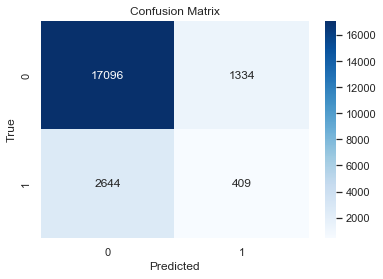

C:\Users\22929\anaconda3\envs\test_env1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\22929\anaconda3\envs\test_env1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\22929\anaconda3\envs\test_env1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


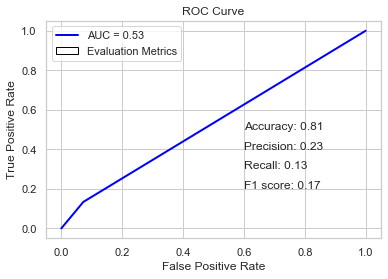

In [23]:
from sklearn import metrics
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc={'axes.formatter.limits': (-5, 5)})

def binarize(x):
    if x > 15:
        return 1
    else:
        return 0

node_labels_bin = [binarize(x) for x in test_labels]
pred_bin = [binarize(x) for x in test_pred]

# 混淆矩阵
cm = metrics.confusion_matrix(node_labels_bin, pred_bin)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 真正率和假正率
fpr, tpr, thresholds = metrics.roc_curve(node_labels_bin, pred_bin)
# AUC
auc = metrics.auc(fpr, tpr)
# AUC曲线
sns.lineplot(x=fpr, y=tpr, lw=2, label=f"AUC = {auc:.2f}", color="blue", linestyle="-", legend=False)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# 准确率、召回率
accuracy = metrics.accuracy_score(node_labels_bin, pred_bin)
precision = metrics.precision_score(node_labels_bin, pred_bin)
recall = metrics.recall_score(node_labels_bin, pred_bin)
f1 = metrics.f1_score(node_labels_bin, pred_bin)
plt.text(x=0.6, y=0.5, s=f"Accuracy: {accuracy:.2f}", fontsize=12)
plt.text(x=0.6, y=0.4, s=f"Precision: {precision:.2f}", fontsize=12)
plt.text(x=0.6, y=0.3, s=f"Recall: {recall:.2f}", fontsize=12)
plt.text(x=0.6, y=0.2, s=f"F1 score: {f1:.2f}", fontsize=12)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
handles = [Line2D([0], [0], color="blue", lw=2, linestyle="-"), Patch(facecolor="white", edgecolor="black")]
labels = [f"AUC = {auc:.2f}", "Evaluation Metrics"]
plt.legend(handles=handles, labels=labels)
plt.show()